# Quantum Phase Estimation

In [1]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt



from qiskit.circuit.library import QFT
# from qiskit_aer import AerSimulator, StatevectorSimulator
# from qiskit_ibm_provider import IBMProvider
# aer_sim = AerSimulator()
# aer_sim = StatevectorSimulator()
# backend = aer_sim
# backend = quantum_hardware
# qc_trans = transpile(circuit, backend, initial_layout=layout, optimization_level=2)

## Objective

The quantum phase estimation algorithm (QPE) is very key for many quantum algorithms. It's goal is to find the eigenvalue of some given eigenstate of a unitary operator. In this problem we are given two things: a unitary operator $U$ and one of its eigenvalues $|\psi\rangle$. As we have previously discussed, because it is a unitary operator, we can write

$$U|\psi\rangle = e^{2\pi i\varphi}|\psi\rangle$$

where $0\leq\varphi<1$. Our goal is to estimate the eigenvalue and thus the phase $\varphi$ of $|\psi\rangle$. Just like with the Hadamard test, the phase of $U$ is written onto our control qubits. But because this is in the Fourier basis, we apply the inverse $\text{QFT}$ to transform it to the computational basis to perform a measurement. Recall from the $\text{QFT}$ section that in the Fourier basis the topmost qubit completes one rotation when counting from $0$ to $2^n$ where $n$ is the number of control qubits. For example, to count to some number $x$ between $0$ and $2^n$, the rotation of the first three qubits $R_{q_{n}}$ around the $z$-axis is as follows:

$$R_{q_0} = \frac{x}{2^n} \qquad R_{q_1} = \frac{2x}{2^n} \qquad R_{q_2} = \frac{4x}{2^n}$$

When performing a controlled-$U$ operation, as we mentioned before, the qubit will proportionally rotate to the phase $e^{2\pi i \varphi}$. In order to correctly encode the phase $\varphi$ (a number between $0$ and $2^n$), we can apply $C-U$ gates in succession to repeat this rotation a number of times until the phase $\varphi$ has been applied in the Fourier basis. Then by using the inverse $\text{QFT}$ we transform it to the computational basis for measurement.  

## Proof

Let's walk through the math of this procedure and how it is implemented as a circuit. We start with some state $|\psi\rangle$ as one set of qubit registers and $n$ counting qubits making up the counting register. Because all of our qubits start in the state $|0\rangle$, we can represent the initial state of our circuit as

$$|\psi_0\rangle = |0\rangle^{\otimes n}|\psi\rangle$$

To put each counting qubit into superposition we then apply a Hadamard gate to all $n$ qubits putting our circuit in the state

$$|\psi_1\rangle = \frac{1}{\sqrt{2^n}}(|0\rangle + |1\rangle)^{\otimes n}|\psi\rangle$$

We then apply our $C-U$ gates. Since we already know that $U|\psi\rangle = e^{2\pi i\varphi}|\psi\rangle$, when applying this gate to all $n$ qubits, it then follows that 

$$U^{2^j}|\psi\rangle = U^{2^{j}-1}U|\psi\rangle = U^{2^{j}-1}e^{2\pi i \varphi}|\psi\rangle = U^{2^{j}-2}e^{4\pi i \varphi}|\psi\rangle = \dots = e^{2\pi i 2^j \varphi}|\psi\rangle$$

Therefore, by controlling this gate and applying it to all $n$ qubits, we must apply $C-U^{2^j}$ where $0 \leq j \leq n-1$. This leaves us with

$$|\psi_2\rangle = \frac{1}{\sqrt{2^n}}\left(|0\rangle + e^{2\pi i \varphi 2^{n-1}}|1\rangle\right)\otimes \left(|0\rangle + e^{2\pi i \varphi 2^{n-2}}|1\rangle\right) \otimes \dots \otimes \left(|0\rangle + e^{2\pi i \varphi 2^{0}}|1\rangle\right)\otimes|\psi\rangle= \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1}e^{2\pi i \varphi k}|k\rangle\otimes|\psi\rangle$$

Here, $k$ is the integer representation of $n$-bit binary numbers. When looking at this equation we can see that it is actually the same as implementing the $\text{QFT}$ into a quantum circuit. When applying an $n$-qubit $\text{QFT}$ to some state $|X\rangle$, we know that it is then mapped to the state

$$QFT|X\rangle = \frac{1}{\sqrt{2^n}}\left(|0\rangle + e^{\frac{2\pi i X}{2}}|1\rangle\right)\otimes\left(|0\rangle + e^{\frac{2\pi i X}{2^2}}|1\rangle\right)\otimes \dots \otimes \left(|0\rangle + e^{\frac{2\pi i X}{2^{n-1}}}|1\rangle\right)\otimes \left(|0\rangle + e^{\frac{2\pi i X}{2^n}}|1\rangle\right)$$ 

By replacing $X$ with $2^n\varphi$, we obtain the same expression as $|\psi_2\rangle$ thus we can say it is the same as the $\text{QFT}$. So in order to recover the state $2^n\varphi$, the inverse of the Fourier transform must be applied as shown

$$|\psi_4\rangle = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1}e^{2\pi i \varphi k}|k\rangle\otimes|\psi\rangle \xrightarrow{QFT^{\dagger}} \frac{1}{2^n}\sum_{X=0}^{2^n-1} \sum_{k=0}^{2^n-1}e^{-\frac{2\pi i k}{2^n}(X-2^n\varphi)}|X\rangle\otimes|\psi\rangle$$

When performing a measurement, we can see from the expression that it will peak near $X = 2^n\varphi$ thus allowing us to estimate the phase $\varphi$.

show that we can measure phase using inverse qft (similar process to proving qft)

## Verification

In [2]:
def add_inv_fourier_transform(circuit, qubits, show_steps = False):
    circuit.barrier()
    for i in range(int(qubits/2)):
        circuit.swap(i, qubits-i-1)
    for highest in range(qubits):
        if show_steps: print("\nPreforming inverse transform on qubit", highest)
        circuit.barrier()
        for qubit in range(highest):
            # qubit = highest-j-1
            if show_steps: print("\tControl Phase -π/2^"+str(highest-qubit)+" gate applied to", highest, "using qubit", qubit, "as control")
            circuit.cp(-pi/2**(highest-qubit), highest, qubit)
        if show_steps: print("\tAdding H gate to qubit", highest)
        circuit.h(highest) 
    if show_steps: print("\nCompleted transformation\n")

def setup(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        circuit.h(i)

def measure(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        qc.measure(i,i)

In [30]:
ancilla_bits = 5
angle = 1/8

In [31]:
print("Decimal Representation of the phase angle:", angle)
reading_angle = angle
print("Binary Representation of the phase angle:  0.", end="")
for i in range(1,ancilla_bits+1):
    if reading_angle - 1/2**i >= 0:
        reading_angle -= 1/2**i
        print("1", end="")
    else:
        print("0", end="")
print()

Decimal Representation of the phase angle: 0.125
Binary Representation of the phase angle:  0.00100


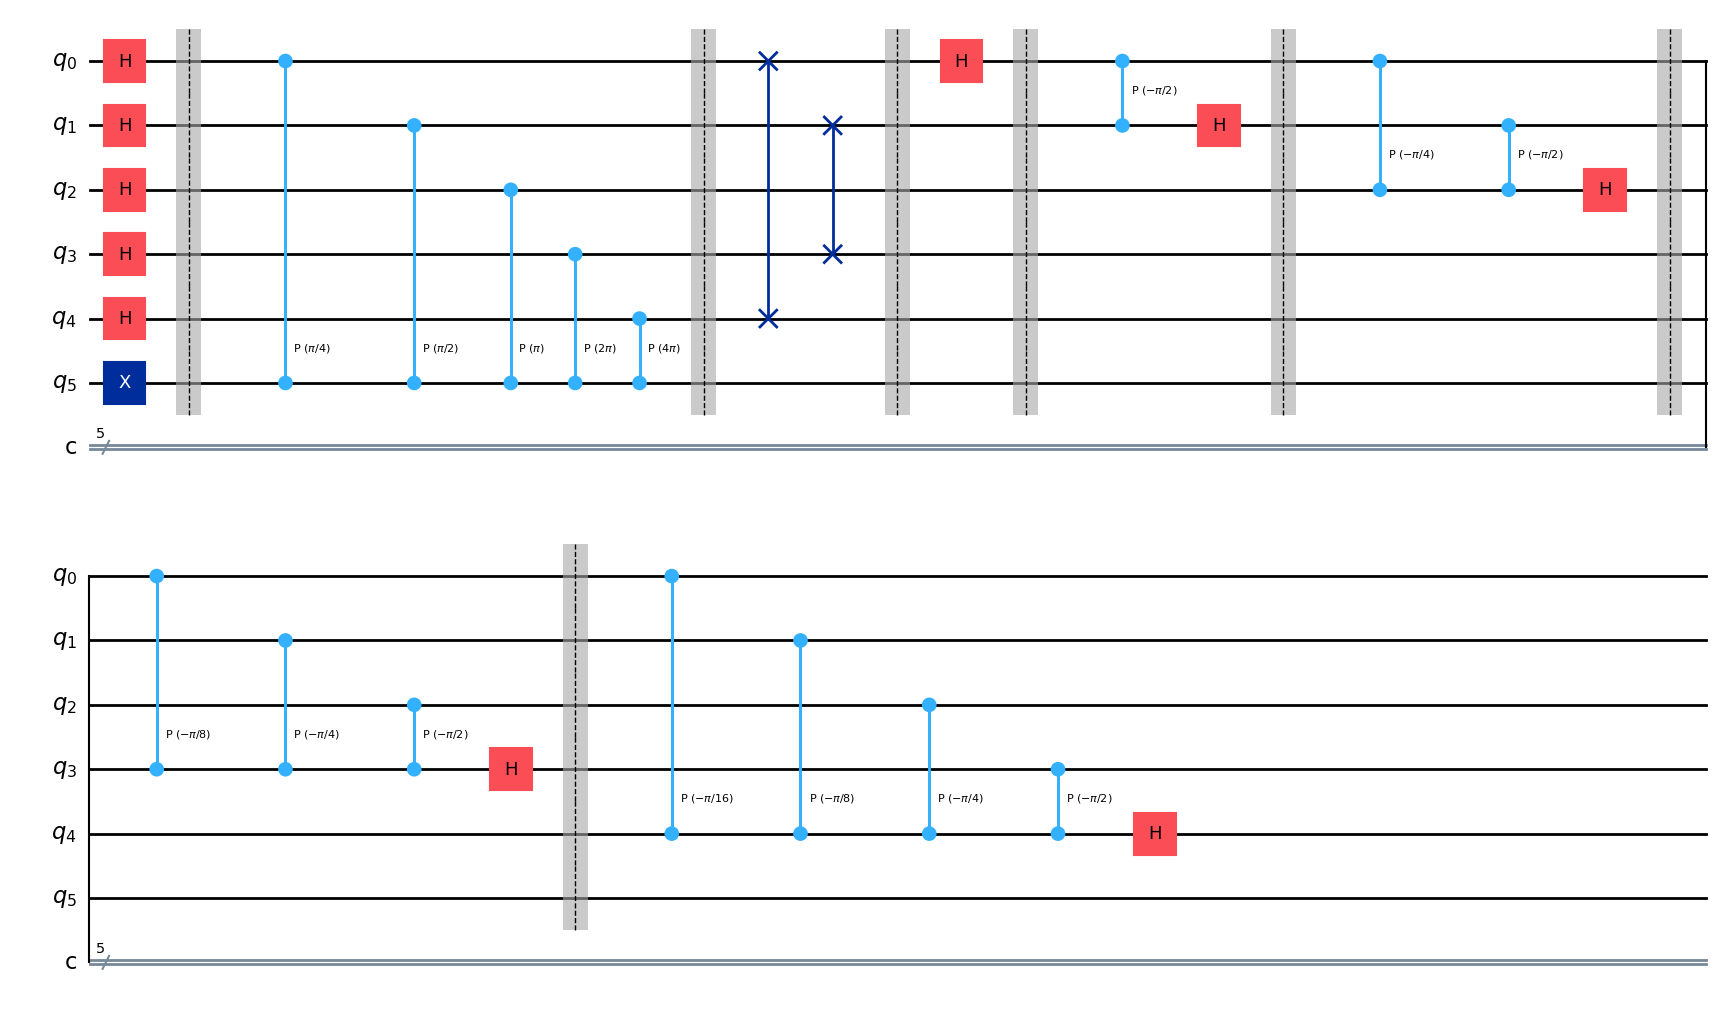

In [32]:
qc = QuantumCircuit(ancilla_bits+1, ancilla_bits)
setup(qc, ancilla_bits)
qc.x(ancilla_bits)
qc.barrier()
for i in range(ancilla_bits):
    qc.cp((2*pi*angle)*2**(i), ancilla_bits,i)

add_inv_fourier_transform(qc,ancilla_bits)

# qr_ancilla = QuantumRegister(ancilla_bits)
# print(qr_ancilla

# qc.append(QFT(ancilla_bits).inverse(), ancilla_bits)
qc.compose(QFT(ancilla_bits, inverse = True), range(ancilla_bits))
qc.draw('mpl')

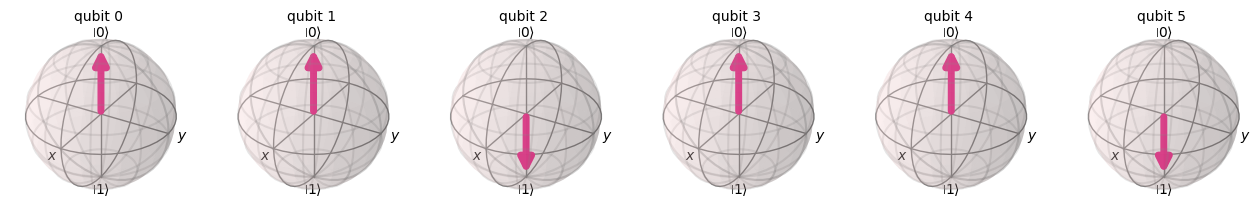

In [33]:
sv = Statevector(qc)
plot_bloch_multivector(sv)

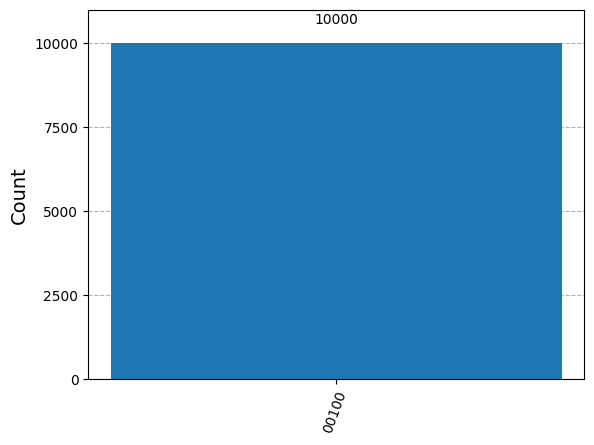

In [34]:
measure(qc, ancilla_bits)
backend = BasicSimulator()
result = backend.run(qc, shots=10000).result()   
counts = result.get_counts()                    
plot_histogram(counts)

In [35]:
binary_num = ''
max_num = 0
for key in counts:
    if (counts[key] > max_num):
        max_num = counts[key]
        binary_num = key
print("Binary Number with Maximum count:     0."+binary_num)
decimal_num = 0
for i in range(len(binary_num)):
    decimal_num += int(binary_num[i])/2**(i+1)
print("Decimal Number with Equivalent Value:",decimal_num)

Binary Number with Maximum count:     0.00100
Decimal Number with Equivalent Value: 0.125


In [11]:



# # Controlled-U operations
# for i in range(m):
#     #mat = np.linalg.matrix_power(U, 2**(m-i-1))
#     mat = np.linalg.matrix_power(U, 2**(i))
#     controlled_U = UnitaryGate(mat).control()
#     qc.append(controlled_U, [qr_ancilla[i]] + qr_eigenstate[:])

# # Compute 2πiH
# two_pi_i_H = 2 * np.pi * 1j * H

# # Compute the unitary matrix U = exp(2πiH)
# U = expm(two_pi_i_H)

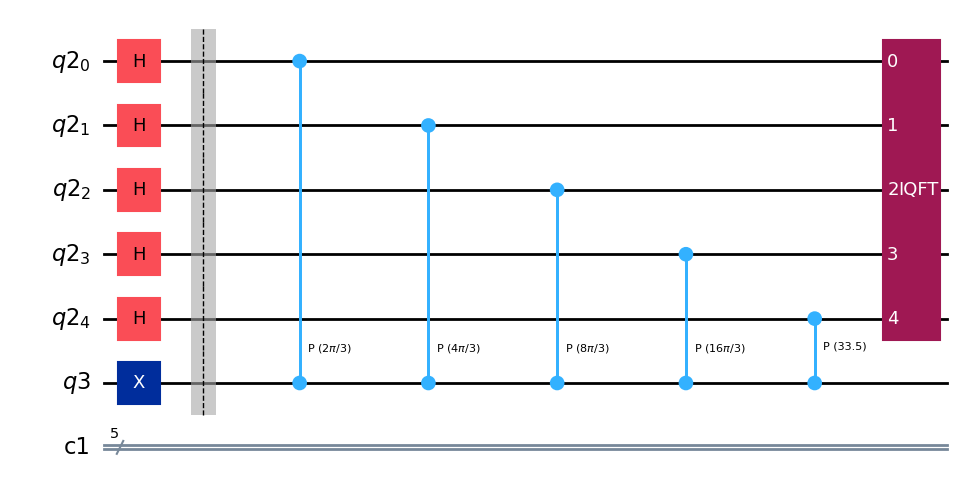

In [27]:
angle = 1/3
qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(1)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

setup(qc, ancilla_bits)
qc.x(ancilla_bits)
qc.barrier()
for i in range(ancilla_bits):
    qc.cp((2*pi*angle)*2**(i), ancilla_bits,i)

qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
# measure(qc, ancilla_bits)
qc.draw('mpl')

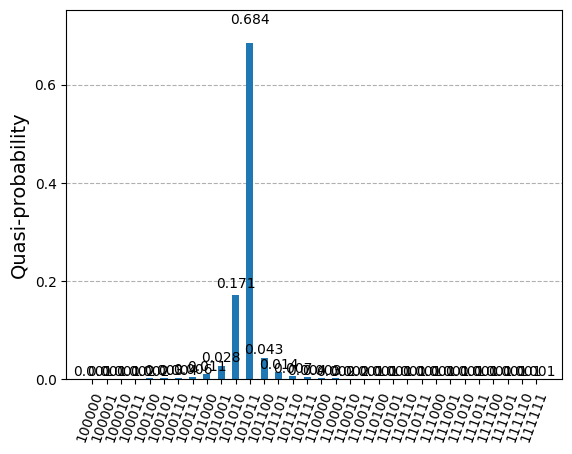

In [28]:
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
plot_histogram(ideal_distribution)



In [29]:
max_num = 0
binary_num = ''
for key in ideal_distribution:
    if (ideal_distribution[key] > max_num):
        max_num = ideal_distribution[key]
        binary_num = key

print(binary_num)

decimal_num = 0
for i in range(1,len(binary_num)):
    decimal_num += int(binary_num[i])/2**(i)
print("Decimal Number with Equivalent Value:",decimal_num)

101011
Decimal Number with Equivalent Value: 0.34375
